import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Reshape,ZeroPadding2D,MaxPool2D,Conv1D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout,BatchNormalization, MaxPooling1D, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras import layers
from keras import regularizers
from keras.layers import Convolution1D ,Convolution2D, MaxPooling2D
import keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model, Sequential
import gc

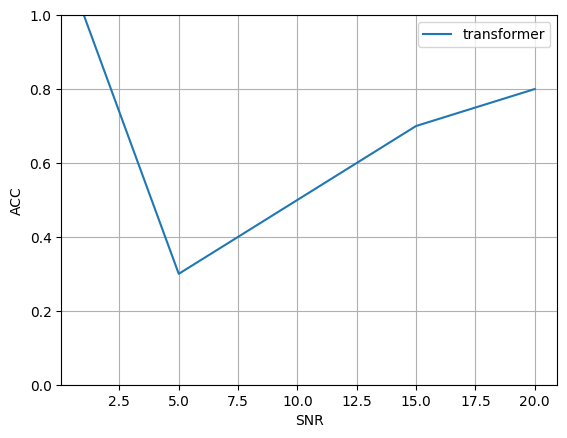

In [5]:
x = [1, 5, 10, 15, 20]
y = [1, 0.3, 0.5, 0.7, 0.8]
plt.plot(x,y, label='transformer')
plt.legend()
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [2]:
f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
idx = np.random.choice(range(sample_num), size=sample_num)
# idx = np.random.choice(range(0,sample_num), size=sample_num//20)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    filename = 'ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    gc.collect()
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

ExtractDataset/part1.h5
ExtractDataset/part2.h5
ExtractDataset/part3.h5
ExtractDataset/part4.h5
ExtractDataset/part5.h5
ExtractDataset/part6.h5
ExtractDataset/part7.h5
ExtractDataset/part8.h5
ExtractDataset/part9.h5
ExtractDataset/part10.h5
ExtractDataset/part11.h5
ExtractDataset/part12.h5
ExtractDataset/part13.h5
ExtractDataset/part14.h5
ExtractDataset/part15.h5
ExtractDataset/part16.h5
ExtractDataset/part17.h5
ExtractDataset/part18.h5
ExtractDataset/part19.h5
ExtractDataset/part20.h5
ExtractDataset/part21.h5
ExtractDataset/part22.h5
ExtractDataset/part23.h5
X-size： (748800, 1024, 2)
Y-size： (748800, 24)
Z-size： (748800, 1)


In [3]:
n_examples = X.shape[0]
# n_train = int(n_examples * 0.9877)
n_train = int(n_examples * 0.9)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
Z_train = Z[train_idx]
Z_test = Z[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (673920, 1024, 2)
Y_train: (673920, 24)
X_test: (74880, 1024, 2)
Y_test: (74880, 24)


In [4]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def get_config(self):
        cfg = super().get_config()
        return cfg    
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs//128)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [6]:
def proposed_model(X_train,classes):

    embed_dim = 1024  # Embedding size for each token
    num_heads = 128  # Number of attention heads
    ff_dim = 256  # Hidden layer size in feed forward network inside transformer

    in_shp = X_train.shape[1:]   #Dimensions of each sample

    #input layer
    X_input = Input(in_shp)
    X = Reshape([2,1024], input_shape=in_shp)(X_input)

    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(X)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation="selu")(x)
    x = Dropout(0.2)(x)
    x = Dense(len(classes), activation="softmax")(x)
    return tf.keras.models.Model(inputs=X_input, outputs=x)
    
model = proposed_model(X_train, classes) 

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 2)]         0         
                                                                 
 reshape (Reshape)           (None, 2, 1024)           0         
                                                                 
 transformer_block (Transfor  (None, 2, 1024)          537794816 
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 1024)             0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              104960

In [ ]:
gc.collect()
filepath = 'test_model.keras'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=3,
    verbose=1,
    # validation_data=(X_test, Y_test),
    validation_split = 0.2,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy ',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
acc={}
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    
        j = list(Y_test_snr[i,:]).index(1)  
        k = int(np.argmax(pre_Y_test[i,:])) 
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.ylim(0, 1)
plt.grid(True)
plt.show()